In [20]:
import sys
import os
sys.path.append('/Users/zhoupeng/Desktop/Athena')

In [21]:
from athena import Strategy, Backtest
from athena.data import TushareDataHandler
import pandas as pd
import matplotlib.pyplot as plt

from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [22]:
# import pandas as pd
# 设置全局浮点数格式
# pd.options.display.float_format = '{:,.2f}'.format

In [23]:
from dotenv import load_dotenv
load_dotenv()

tushare_token = os.getenv('tushare_token')

In [24]:
# tushare数据支持
data_handler = TushareDataHandler(start_date='20200101', end_date='20241201', token=tushare_token)

In [25]:
benchmark = data_handler.get_index_prices_from_tushare('399300.SZ')

In [26]:
# 获取指数成分
stock_list = data_handler.get_index_list(index_code='000300.SH') # 沪深300指数
len(stock_list)

312

In [27]:
# prices_df = data_handler.get_prices_from_tushare(stock_list, fields=['open', 'close'], sleep_time=0.5)
prices_df = pd.read_hdf('../athena/data/large_prices_data_multi_sort.h5', key='prices')

In [28]:
# factors_df = data_handler.get_factors_from_tushare(stock_list, factors=['total_mv', 'pe_ttm'], sleep_time=0.5)
factors_df = pd.read_hdf('../athena/data/large_factors_data_multi_sort.h5', key='factors')

In [29]:
# total_mv - 规模因子 越低越有溢价
# pe_ttm - 价值因子 越低越有溢价

In [30]:
from athena.lib import classify_factors_into_buckets # 分组股票

In [31]:
# 独立双重排序法
class SortedFactorInvestStrategy(Strategy):
    def init(self):
        pass

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(str(date) + ': ')

        current_long_positions, current_short_positions = self.broker.current_position_status()
        #print("我目前持仓情况:")
        #print("多头仓位:", current_long_positions)
        #print("空头仓位:", current_short_positions)

        day_factors = factors_df.loc[date] # 当天的因子数据

        # 因子排序
        sorted_factor1_series = sort_the_factor(day_factors, 'total_mv') # 因子1从高到低排排序
        sorted_factor2_series = sort_the_factor(day_factors, 'pe_ttm') # 因子2从高到低排因子

        # 因子分组（5个桶）
        factor1_buckets = classify_factors_into_buckets(sorted_factor1_series, 5, ascending=False) # 从高到低排，因为越低溢价越大
        factor2_buckets = classify_factors_into_buckets(sorted_factor2_series, 5, ascending=False) # 从高到低排，因为越低溢价越大

        long_stock_buckets = {}
        short_stock_buckets = {}

        # 找到所有暴露因子高的组合（如 P51 到 P55）
        for factor1_high_bucket in [5]:
            for factor2_high_bucket in range(1, 6):  # 因子2高，因子1遍历1-5
                factor1_target_stocks = sorted_factor1_series[factor1_buckets == factor1_high_bucket].index.tolist()
                factor2_target_stocks = sorted_factor2_series[factor2_buckets == factor2_high_bucket].index.tolist()

                # 两组股票取交集
                intersect_stocks = list(set(factor1_target_stocks) & set(factor2_target_stocks))
                long_stock_buckets[f'P{factor1_high_bucket}{factor2_high_bucket}'] = intersect_stocks


        # 找到所有暴露因子低的组合（如 P11 到 P15）
        for factor1_low_bucket in [1]:
            for factor2_low_bucket in range(1, 6):  
                factor1_target_stocks = sorted_factor1_series[factor1_buckets == factor1_low_bucket].index.tolist()
                factor2_target_stocks = sorted_factor2_series[factor2_buckets == factor2_low_bucket].index.tolist()

                # 两组股票取交集
                intersect_stocks = list(set(factor1_target_stocks) & set(factor2_target_stocks))
                short_stock_buckets[f'P{factor1_low_bucket}{factor2_low_bucket}'] = intersect_stocks
        
        # 新一轮需要进行操作的股票
        long_stocks = [stock for sublist in long_stock_buckets.values() for stock in sublist]
        short_stocks = [stock for sublist in short_stock_buckets.values() for stock in sublist]
        all_target_stocks = set(long_stocks + short_stocks)
        
        # 清仓
        open_positions = set(current_long_positions + current_short_positions)
        for stock in open_positions:
            if stock not in all_target_stocks:
                self.broker.close(symbol=stock, price=record[(stock, "Open")])

        # 等权重的做多高排名组合P51-P55
        for _, stocks in long_stock_buckets.items():
            if len(stocks) > 0:
                weight_per_stock = (0.1 / len(stocks))  # 每只股票百分比
                for stock in stocks:
                    self.broker.order_target_percent(stock, weight_per_stock, record[(stock, "Close")], short=False)

        # 等权重的做空低排名组合P11-P15
        for _, stocks in short_stock_buckets.items():
            if len(stocks) > 0:
                weight_per_stock = (0.1 / len(stocks))  # 每只股票百分比
                for stock in stocks:
                    self.broker.order_target_percent(stock, weight_per_stock, record[(stock, "Close")], short=True)


        print(long_stock_buckets)
        print(short_stock_buckets)

        print("----------------------")

backtest = Backtest(SortedFactorInvestStrategy, prices_df, commission=.001, cash=100_0000, benchmark=benchmark)
res = backtest.run()

----------------------
2020-01-02 00:00:00: 
{'P51': ['600460.SH', '603019.SH', '300661.SZ', '600150.SH', '600489.SH', '002049.SZ', '300223.SZ', '002821.SZ', '002709.SZ', '002920.SZ', '300496.SZ'], 'P52': ['300316.SZ', '601799.SH', '601689.SH', '600161.SH', '603486.SH', '601865.SH', '300751.SZ', '600372.SH', '600132.SH'], 'P53': ['000408.SZ', '600219.SH', '600875.SH', '300763.SZ', '600732.SH', '002603.SZ', '603806.SH', '002074.SZ', '600026.SH', '600754.SH', '600415.SH', '000733.SZ', '601615.SH', '300274.SZ'], 'P54': ['603260.SH', '600089.SH', '000301.SZ', '002601.SZ', '600515.SH', '002648.SZ', '000999.SZ', '300418.SZ', '600426.SH'], 'P55': ['600803.SH', '000983.SZ', '601838.SH', '601699.SH', '000877.SZ', '600039.SH', '601117.SH']}
{'P11': ['603288.SH', '002714.SZ', '000725.SZ', '600276.SH'], 'P12': ['601888.SH', '600050.SH', '601066.SH', '600519.SH', '300750.SZ', '300760.SZ', '002475.SZ'], 'P13': ['601138.SH', '601688.SH', '300498.SZ', '002415.SZ', '601360.SH', '002352.SZ', '000858.SZ'

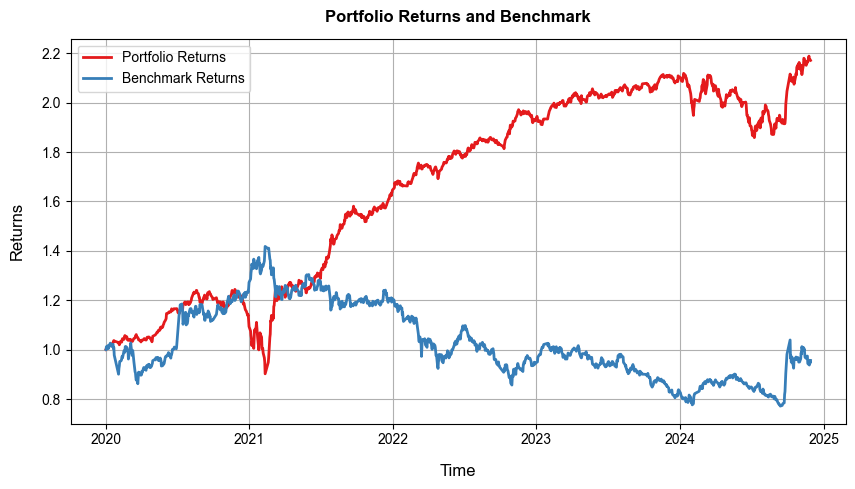

In [32]:
from athena.plotting import Visualization

visualization = Visualization(res)
visualization.plot_portfolio_returns()

In [33]:
# 计算回测指标
metrics = visualization.calculate_metrics()
print("Backtest Metrics: \n")
for key, value in metrics.items():
    print(key+": "+ value)

Backtest Metrics: 

strategy_annualized_return: 17.84%
benchmark_annualized_return: -0.95%
strategy_annualized_volatility: 12.94%
benchmark_annualized_volatility: 19.71%
strategy_max_drawdown: -27.48%
benchmark_max_drawdown: -45.60%
sharpe_ratio: 1.22
alpha: 22.23%


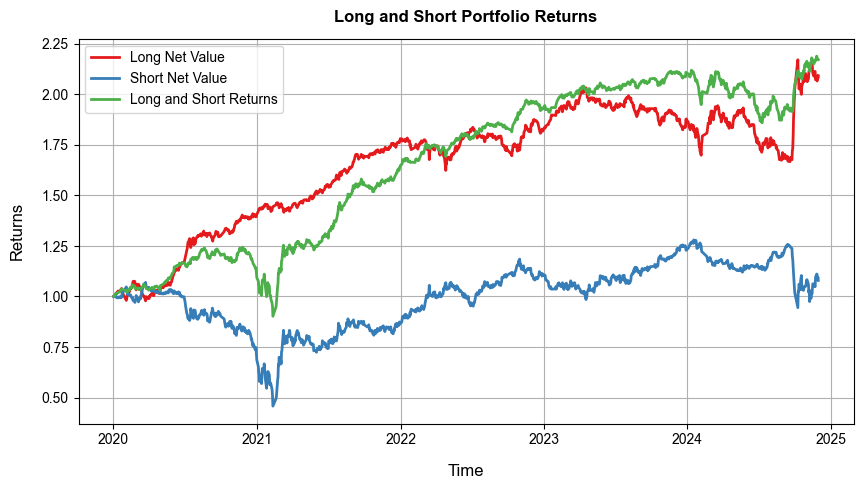

In [34]:
visualization.plot_long_short_portfolio_returns()

In [35]:
# 条件双重排序法
class SortedFactorInvestStrategy(Strategy):
    def init(self):
        pass

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        # 当前日期
        date = self.data.index[i]
        print(str(date) + ": ")

        # 当前的多空持仓
        current_long_positions, current_short_positions = self.broker.current_position_status()

        # 获取当天因子数据
        day_factors = factors_df.loc[date]

        # 控制条件排序的分组数
        L1 = 5  # 用 `factor1` 分的组数
        L2 = 5  # 在每组中用 `factor2` 进一步分的组数

        # 因子排序
        sorted_factor1_series = sort_the_factor(day_factors, 'total_mv') # 因子1从高到低排排序
        sorted_factor2_series = sort_the_factor(day_factors, 'pe_ttm') # 因子2从高到低排因子

        # 用 `factor1` 排序并分为 L1 个组
        factor1_buckets = classify_factors_into_buckets(sorted_factor1_series, L1, ascending=False)

        # 初始化多头与空头分组
        long_stock_buckets = {}
        short_stock_buckets = {}

        # 在每个 `factor1` 组内进一步用 `factor2` 排序分子组 (条件排序)
        for factor1_group in range(1, L1 + 1):  # 遍历 factor1 的每个组
            # 当前 `factor1` 组的股票
            factor1_target_stocks = sorted_factor1_series[factor1_buckets == factor1_group].index.tolist()

            # 过滤获取两因子同时存在的股票（交集）
            valid_stocks = list(set(factor1_target_stocks) & set(sorted_factor2_series.index))
            factor2_subset = sorted_factor2_series.loc[valid_stocks]

            # 过滤符合当前组的factor2股票, 只选出当前因子1组内的因子2值
            # factor2_subset = sorted_factor2_series.loc[factor1_target_stocks]

            # 在当前 `factor1` 组内，用 `factor2` 再次排序分为 L2 组
            factor2_buckets = classify_factors_into_buckets(
                factor2_subset, L2, ascending=False
            )

            # 遍历 `factor2` 的每个子组
            for factor2_group in range(1, L2 + 1):
                # 获取当前子组的股票
                sub_group_stocks = factor2_subset[factor2_buckets == factor2_group].index.tolist()

                # 如果是高因子组合 (e.g., P51 ~ P55)
                if factor1_group == L1:  
                    group_key = f'P{factor1_group}{factor2_group}'
                    long_stock_buckets[group_key] = sub_group_stocks

                # 如果是低因子组合 (e.g., P11 ~ P15)
                if factor1_group == 1:  # 只取因子1的最低组
                    group_key = f'P{factor1_group}{factor2_group}'
                    short_stock_buckets[group_key] = sub_group_stocks

        # 新一轮需要操作的股票组合
        long_stocks = [stock for sublist in long_stock_buckets.values() for stock in sublist]
        short_stocks = [stock for sublist in short_stock_buckets.values() for stock in sublist]
        all_target_stocks = set(long_stocks + short_stocks)

        # 清仓
        open_positions = set(current_long_positions + current_short_positions)
        for stock in open_positions:
            if stock not in all_target_stocks:
                self.broker.close(symbol=stock, price=record[(stock, "Open")])

        # 等权重的做多高排名组合P51-P55
        for _, stocks in long_stock_buckets.items():
            if len(stocks) > 0:
                weight_per_stock = (0.1 / len(stocks))  # 每只股票百分比
                for stock in stocks:
                    self.broker.order_target_percent(stock, weight_per_stock, record[(stock, "Close")], short=False)

        # 等权重的做空低排名组合P11-P15
        for _, stocks in short_stock_buckets.items():
            if len(stocks) > 0:
                weight_per_stock = (0.1 / len(stocks))  # 每只股票百分比
                for stock in stocks:
                    self.broker.order_target_percent(stock, weight_per_stock, record[(stock, "Close")], short=True)

        print(long_stock_buckets)
        print(short_stock_buckets)
        print("----------------------")

backtest = Backtest(SortedFactorInvestStrategy, prices_df, commission=.001, cash=100_0000, benchmark=benchmark)
res = backtest.run()

----------------------
2020-01-02 00:00:00: 
{'P51': ['300661.SZ', '300496.SZ', '600460.SH', '600489.SH', '300223.SZ', '002920.SZ', '603019.SH', '600150.SH', '002049.SZ', '002709.SZ'], 'P52': ['601799.SH', '600161.SH', '603486.SH', '300751.SZ', '600132.SH', '300316.SZ', '601689.SH', '002821.SZ', '601865.SH', '600372.SH'], 'P53': ['601615.SH', '000408.SZ', '600415.SH', '600732.SH', '002074.SZ', '600026.SH', '603806.SH', '600754.SH', '000733.SZ', '300763.SZ'], 'P54': ['600219.SH', '300418.SZ', '600089.SH', '600515.SH', '300274.SZ', '603260.SH', '600875.SH', '000301.SZ', '002603.SZ', '002648.SZ'], 'P55': ['000877.SZ', '601699.SH', '601117.SH', '600426.SH', '000983.SZ', '600803.SH', '601838.SH', '000999.SZ', '002601.SZ', '600039.SH']}
{'P11': ['603288.SH', '601066.SH', '000725.SZ', '300760.SZ', '601888.SH', '600519.SH', '000858.SZ', '002714.SZ', '300750.SZ', '600276.SH', '600050.SH', '002475.SZ'], 'P12': ['601138.SH', '002415.SZ', '300498.SZ', '600030.SH', '600887.SH', '002304.SZ', '601360

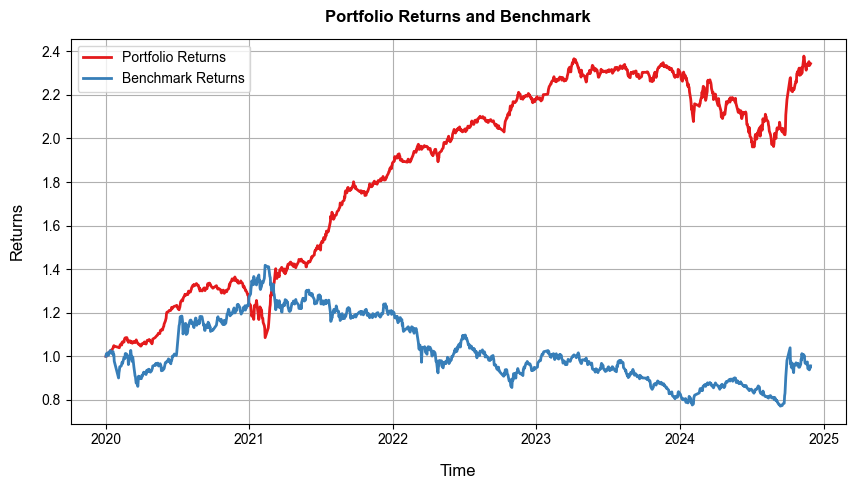

In [36]:
from athena.plotting import Visualization

visualization = Visualization(res)
visualization.plot_portfolio_returns()

In [37]:
# 计算回测指标
metrics = visualization.calculate_metrics()
print("Backtest Metrics: \n")
for key, value in metrics.items():
    print(key+": "+ value)

Backtest Metrics: 

strategy_annualized_return: 19.76%
benchmark_annualized_return: -0.95%
strategy_annualized_volatility: 11.50%
benchmark_annualized_volatility: 19.71%
strategy_max_drawdown: -20.42%
benchmark_max_drawdown: -45.60%
sharpe_ratio: 1.54
alpha: 24.15%


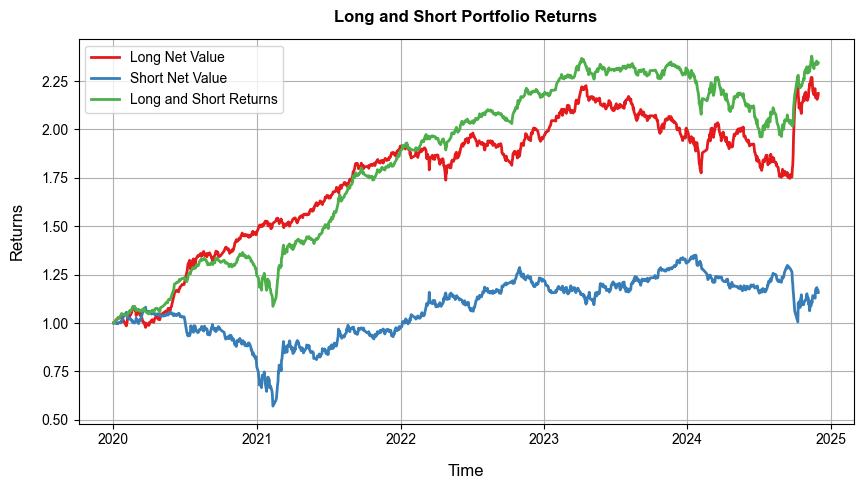

In [38]:
visualization.plot_long_short_portfolio_returns()